In [49]:
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from summary_measures_perpixel import Plotter
import os
import itertools as it
from tqdm import tqdm
from scipy.stats import mannwhitneyu, spearmanr, pearsonr, wilcoxon, linregress
from scipy.interpolate import UnivariateSpline
from scipy.stats.qmc import LatinHypercube

from utils.analysis import *
from utils.constants import *
from utils.paths import *
from utils.extremes import *
from utils.plotting import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import fasttreeshap

In [50]:
self = Plotter('heat_wave')
no_crop = True
use_gap_to_optimalT = False
if use_gap_to_optimalT:
    folder = 'gap_to_optimalT'
else:
    folder = 'optimalT'

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')

""" Collect the predictors and predictands """
if no_crop:
    suffix = '_nocrop'
else:
    suffix = ''

data = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary',
                                f'{self.prefix}_{self.extent}_{self.name}_{self.heat_wave_thres}_{self.hot_and_dry_thres}_{self.extreme}_city_average{suffix}.csv'),
                    index_col = [0, 1, 2], header = [0, 1])

predictors_, luc_clist = self._get_predictors(use_gap_to_optimalT)
predictors_['season'] = predictors_.index.get_level_values('end').month.map(month_to_season)
predictors = predictors_.groupby(['season', 'use', 'fid']).mean()

predictand = pd.DataFrame({
    ('Resistance', 'Sign'): data.loc[:, ('Resistance', 'frac_pos_urban'  )] - data.loc[:, ('Resistance', 'frac_pos_rural'  )], 
    ('Recovery'  , 'Sign'): data.loc[:, ('Recovery'  , 'frac_pos_urban'  )] - data.loc[:, ('Recovery'  , 'frac_pos_rural'  )],
    ('Resistance', 'Mag' ): data.loc[:, ('Resistance', 'median_abs_urban')] - data.loc[:, ('Resistance', 'median_abs_rural')],
    ('Recovery'  , 'Mag' ): data.loc[:, ('Recovery'  , 'median_abs_urban')] - data.loc[:, ('Recovery'  , 'median_abs_rural')]
})

predictand = predictand.sort_index(axis = 1)

In [51]:
predictors.columns

Index(['city_size_log', 'background_prcp', 'background_tmean',
       'dtmax_in_event', 'dtmax_post_event', 'dtmin_in_event',
       'dtmin_post_event', 'spi_in_event', 'spi_post_event', 'vpd_in_event',
       'vpd_post_event', 'Crop', 'Deciduous forest', 'Developed',
       'Evergreen forest', 'Grass', 'Mixed forest', 'Shrub', 'Wetland',
       'impervious_frac', 'event_intensity', 'event_duration', 'elev_diff',
       'optimal_tmax_diff', 'optimal_tmin_diff', 'corr_spi_diff',
       'corr_vpd_diff'],
      dtype='object')

In [7]:
""" Create the parameter samples using Latin Hypercube """
n_samples = 120
samples = LatinHypercube(6, seed = 200).random(n_samples)
params_samples = pd.DataFrame(np.nan, index = range(n_samples), 
                              columns = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_predictors'])
for i in range(n_samples):
    params_samples.loc[i, 'n_estimators'] = 1000 + int(samples[i, 0] * 1500)
    params_samples.loc[i, 'max_depth'] = 3 + int(samples[i, 1] * (predictors.shape[1] - 4 - 3))
    params_samples.loc[i, 'min_samples_split'] = 2 + int(samples[i, 2] * 10)
    params_samples.loc[i, 'min_samples_leaf'] = 2 + int(samples[i, 3] * 5)
    params_samples.loc[i, 'max_features'] = 10 + int(samples[i, 4] * (predictors.shape[1] - 14))
    params_samples.loc[i, 'max_predictors'] = 10 + int(samples[i, 4] * (predictors.shape[1] - 14))

params_samples = params_samples.astype(int)
params_samples.to_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_param_samples{suffix}.csv'))

In [8]:
""" Run the parameter samples and evaluate the OOB performance 
    (Higher OOB scores means lower OOB error which means better performance)

    Takes several hours to run this
"""
R2 = pd.DataFrame(np.nan, index = pd.MultiIndex.from_product([['Resistance', 'Recovery'], ['Sign', 'Mag'], ['DJF', 'MAM', 'JJA', 'SON']]),
                  columns = range(n_samples))
for stat, which, season in tqdm(it.product(['Resistance', 'Recovery'], ['Sign', 'Mag'], ['DJF', 'MAM', 'JJA', 'SON'])):
    if stat == 'Resistance':
        X = predictors.loc[season, :].drop([i for i in predictors.columns if 'post_event' in i], axis = 1)
    else:
        X = predictors.loc[season, :].drop([i for i in predictors.columns if 'in_event' in i], axis = 1)
    Xy = pd.concat([X, predictand.loc[season, [(stat, which)]]], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(Xy.iloc[:, :-1], Xy.iloc[:, -1], test_size = 0.2, random_state = 12)

    for i in range(n_samples):
        max_predictors = params_samples.loc[i, 'max_predictors']
        params = dict(params_samples.loc[i, :].drop('max_predictors'))
        params['criterion'] = 'squared_error'

        mod = RandomForestRegressor(**params, oob_score = True, random_state = i + 100)

        # First pass
        mod_temp = mod.fit(X_train, y_train)
        explainer = fasttreeshap.TreeExplainer(mod_temp, algorithm = 'auto', n_jobs = -1)
        sv = explainer(X_train.values).values
        shap_values = pd.DataFrame(sv, index = X_train.index, columns = X_train.columns)
        predictors_subset = np.argsort(shap_values.abs().mean(axis = 0))[::-1][:max_predictors].index

        # Second pass
        mod = mod.fit(X_train.loc[:, predictors_subset], y_train)

        R2.loc[(stat, which, season), i] = mod.oob_score_ # Returns R-squared

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
R2.to_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_optimizationR2{suffix}.csv'))
R2

0it [00:00, ?it/s]indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact perform

0         1         2         3         4    \
Resistance Sign DJF  0.399698  0.449700  0.453399  0.489942  0.370720   
                MAM  0.202967  0.150450  0.163952  0.144584  0.174615   
                JJA  0.460260  0.530537  0.516392  0.541236  0.477070   
                SON  0.417239  0.418596  0.438182  0.449080  0.408658   
           Mag  DJF  0.537271  0.557761  0.579122  0.585308  0.545984   
                MAM  0.440765  0.474633  0.484130  0.478186  0.428342   
                JJA  0.648820  0.657575  0.663322  0.689050  0.630245   
                SON  0.632261  0.682633  0.666662  0.706645  0.624694   
Recovery   Sign DJF  0.286438  0.293624  0.284651  0.314923  0.238002   
                MAM  0.323016  0.353092  0.331610  0.380964  0.286630   
                JJA  0.482434  0.484178  0.468435  0.539587  0.400015   
                SON  0.372669  0.426589  0.407504  0.469120  0.340726   
           Mag  DJF  0.557324  0.596247  0.587689  0.638890  0.535474   
                MAM  0.412755  0.454836  0.451642  0.514393  0.379275   
                JJA  0.580492  0.663634  0.646708  0.702378  0.578481   
                SON  0.465899  0.520833  0.508843  0.566775  0.463801   

                          5         6         7         8         9    ...  \
Resistance Sign DJF  0.430860  0.416383  0.379555  0.396706  0.412956  ...   
                MAM  0.140709  0.183284  0.175506  0.179680  0.170003  ...   
                JJA  0.513322  0.512409  0.473675  0.495136  0.494781  ...   
                SON  0.407316  0.418750  0.411345  0.429098  0.386160  ...   
           Mag  DJF  0.561350  0.550006  0.503528  0.553723  0.524433  ...   
                MAM  0.438316  0.454987  0.427388  0.453562  0.420881  ...   
                JJA  0.659317  0.659524  0.620770  0.656593  0.628247  ...   
                SON  0.674597  0.676472  0.629713  0.628540  0.646414  ...   
Recovery   Sign DJF  0.280279  0.281594  0.241600  0.284600  0.263238  ...   
                MAM  0.346708  0.345502  0.287000  0.337289  0.308126  ...   
                JJA  0.476144  0.492568  0.403450  0.485499  0.449769  ...   
                SON  0.408278  0.378381  0.336777  0.394358  0.384124  ...   
           Mag  DJF  0.602798  0.585012  0.531030  0.584707  0.550889  ...   
                MAM  0.442982  0.437410  0.376242  0.424296  0.402773  ...   
                JJA  0.654604  0.647142  0.585178  0.610420  0.601050  ...   
                SON  0.512886  0.527239  0.460587  0.481309  0.478914  ...   

                          110       111       112       113       114  \
Resistance Sign DJF  0.411535  0.444160  0.425835  0.436355  0.336538   
                MAM  0.164368  0.174474  0.186325  0.165415  0.168299   
                JJA  0.495034  0.518429  0.505421  0.523020  0.455642   
                SON  0.383324  0.426129  0.436091  0.431798  0.347331   
           Mag  DJF  0.524380  0.565938  0.555482  0.564563  0.484576   
                MAM  0.419409  0.477406  0.467252  0.464638  0.372711   
                JJA  0.630537  0.663318  0.665318  0.664038  0.609861   
                SON  0.645447  0.678504  0.675555  0.681414  0.613988   
Recovery   Sign DJF  0.264158  0.286142  0.304880  0.284697  0.235545   
                MAM  0.305196  0.354498  0.346689  0.348429  0.288064   
                JJA  0.445592  0.497858  0.507287  0.493061  0.410817   
                SON  0.372491  0.408005  0.412337  0.404273  0.321709   
           Mag  DJF  0.548061  0.600240  0.607090  0.600859  0.511973   
                MAM  0.397701  0.453765  0.449993  0.451219  0.346739   
                JJA  0.602328  0.656645  0.646628  0.657301  0.570888   
                SON  0.482855  0.518847  0.517371  0.521666  0.441925   

                          115       116       117       118       119  
Resistance Sign DJF  0.427483  0.375506  0.243254  0.449381  0.437520  
                MAM  0.183852  0.163572  0.141554  0.159345  0.163483  

In [52]:
""" Fit the random forest regressions using optimized hyperparameters
    Use the 3rd best, because slightly better validation performance
"""
R2_optimization = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, 
                                           f'percity_spatial_avg_summary_{fix}_{self.extreme}_optimizationR2{suffix}.csv'),
                              index_col = [0, 1, 2], header = 0)
# best_params_ind = R2_optimization.idxmax(axis = 1).unstack().astype(int)

params_samples = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, 
                                          f'percity_spatial_avg_summary_{fix}_{self.extreme}_param_samples{suffix}.csv'),
                             index_col = 0, header = 0)
R2 = pd.DataFrame(np.nan, index = pd.MultiIndex.from_product([['Resistance', 'Recovery'], ['Sign', 'Mag']]), 
                  columns = ['DJF', 'MAM', 'JJA', 'SON'])
mod_collect = {}
shap_values_collect = {}

for stat, which, season in it.product(['Resistance', 'Recovery'], ['Sign', 'Mag'], ['DJF', 'MAM', 'JJA', 'SON']):
    if stat == 'Resistance':
        X = predictors.loc[season, :].drop([i for i in predictors.columns if 'post_event' in i], axis = 1)
    else:
        X = predictors.loc[season, :].drop([i for i in predictors.columns if 'in_event' in i], axis = 1)
    #X_mean = X.mean(axis = 0)
    #X_std = X.std(axis = 0) ; normalization is apparently handled internally
    Xy = pd.concat([X, predictand.loc[season, [(stat, which)]]], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(Xy.iloc[:, :-1], Xy.iloc[:, -1], test_size = 0.2, random_state = 12)

    # finalized parameters after optimization
    # params_best_index = best_params_ind.loc[(stat, which), season]
    params_best_index = np.argsort(R2_optimization.loc[(stat, which, season), :]).values[-3]
    params = params_samples.loc[params_best_index]
    max_predictors = params.loc['max_predictors']
    params = dict(params.drop('max_predictors'))
    params['criterion'] = 'squared_error'

    mod = RandomForestRegressor(**params, oob_score = True, random_state = 220)

    # First pass
    mod_temp = mod.fit(X_train, y_train)
    explainer = fasttreeshap.TreeExplainer(mod_temp, algorithm = 'auto', n_jobs = -1)
    sv = explainer(X_train.values).values
    shap_values = pd.DataFrame(sv, index = X_train.index, columns = X_train.columns)
    predictors_subset = np.argsort(shap_values.abs().mean(axis = 0))[::-1][:max_predictors].index

    # Second pass
    mod_collect[(stat, which, season)] = mod.fit(X_train.loc[:, predictors_subset], y_train)
    R2.loc[(stat, which), season] = mod_collect[(stat, which, season)].score(X_test[predictors_subset], y_test) # Returns R-squared

    explainer = fasttreeshap.TreeExplainer(mod_collect[(stat, which, season)], algorithm = 'auto', n_jobs = -1)
    sv = explainer(X.loc[:, predictors_subset].values).values
    shap_values_collect[(stat, which, season)] = pd.DataFrame(sv, index = X.loc[:, predictors_subset].index, columns = predictors_subset)

R2.to_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_fitR2{suffix}.csv'))
R2

DJF       MAM       JJA       SON
Resistance Sign  0.575495  0.204260  0.612875  0.245708
           Mag   0.654795  0.630113  0.848420  0.730235
Recovery   Sign  0.537419  0.481374  0.370888  0.305427
           Mag   0.691035  0.643949  0.801552  0.600858

In [54]:
""" Save the importance values of the predictors """
importance = {}
for stat, which, season in it.product(['Resistance', 'Recovery'], ['Sign', 'Mag'], ['DJF', 'MAM', 'JJA', 'SON']):
    importance[(stat, which, season)] = shap_values_collect[(stat, which, season)].abs().mean(axis = 0)
importance = pd.DataFrame(importance).loc[predictors.columns[predictors.columns != 'city_size_log'], :]

for g in ['dtmax_in/post_event', 'dtmin_in/post_event', 'spi_in/post_event', 'vpd_in/post_event']:
    importance.loc[g, 'Resistance'] = importance.loc[g.replace('_in/post_event', '_in_event'), 'Resistance'].values
    importance.loc[g, 'Recovery'] = importance.loc[g.replace('_in/post_event', '_post_event'), 'Recovery'].values

importance = importance.drop(['dtmax_in_event', 'dtmax_post_event', 'dtmin_in_event', 'dtmin_post_event', 'spi_in_event', 'spi_post_event', 'vpd_in_event', 'vpd_post_event'], axis = 0)

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
importance.to_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_importance{suffix}.csv'))

importance

Resistance                                          \
                          Sign                                     Mag   
                           DJF       MAM       JJA       SON       DJF   
background_prcp            NaN       NaN       NaN       NaN  0.005331   
background_tmean           NaN       NaN       NaN       NaN  0.000550   
Crop                  0.001946       NaN  0.003742  0.001570  0.009295   
Deciduous forest      0.006008       NaN  0.004527  0.000880  0.000276   
Developed             0.002017       NaN  0.001312  0.001527  0.000725   
Evergreen forest      0.001035       NaN  0.000476  0.003344  0.004071   
Grass                 0.001709  0.004391  0.002334  0.001851  0.000561   
Mixed forest          0.001400  0.001421  0.000983  0.001264  0.002085   
Shrub                 0.002233  0.001273  0.003259  0.003092  0.004423   
Wetland               0.001806  0.000788  0.000996  0.001143  0.000659   
impervious_frac       0.001521  0.005281  0.000884  0.001076  0.001544   
event_intensity       0.000660  0.001535  0.001996  0.001862  0.000443   
event_duration        0.000932  0.000826  0.000797  0.001523  0.000512   
elev_diff             0.001146  0.000810  0.000566  0.002819  0.002288   
optimal_tmax_diff     0.000707  0.002180  0.002848  0.001986  0.000787   
optimal_tmin_diff     0.003477  0.001935  0.000598  0.000558  0.000569   
corr_spi_diff         0.005243  0.002401  0.006503  0.015096  0.000775   
corr_vpd_diff         0.003936  0.008395  0.004088  0.003932  0.001000   
dtmax_in/post_event        NaN       NaN       NaN       NaN  0.000918   
dtmin_in/post_event   0.000600       NaN  0.000957       NaN  0.000429   
spi_in/post_event     0.003187       NaN  0.002568       NaN  0.000758   
vpd_in/post_event     0.003671       NaN  0.002363       NaN  0.000449   

                                                   Recovery            \
                                                       Sign             
                          MAM       JJA       SON       DJF       MAM   
background_prcp           NaN       NaN       NaN       NaN       NaN   
background_tmean          NaN       NaN       NaN       NaN       NaN   
Crop                 0.005863  0.003390  0.007177  0.001986  0.001408   
Deciduous forest     0.011689  0.001565  0.004710  0.007285  0.000902   
Developed            0.001593  0.001987  0.001958  0.001667  0.002760   
Evergreen forest     0.001547  0.004508  0.002468  0.002655  0.001298   
Grass                0.000896  0.000659  0.002069  0.007850  0.005718   
Mixed forest         0.003013  0.001937  0.004836  0.000796  0.001955   
Shrub                0.002480  0.021444  0.006848  0.000947  0.001490   
Wetland              0.001962  0.000739  0.000481  0.002412  0.003811   
impervious_frac      0.005402  0.001645  0.001479  0.001870  0.004334   
event_intensity      0.005977  0.002830  0.000437  0.001599  0.002385   
event_duration       0.000779  0.003020  0.002284  0.001876  0.001593   
elev_diff            0.000721  0.000841  0.002314  0.001482  0.002293   
optimal_tmax_diff    0.002780  0.001342  0.000717  0.003199  0.008723   
optimal_tmin_diff    0.001662  0.000926  0.000981  0.002106  0.001510   
corr_spi_diff        0.001158  0.000530  0.000554  0.001119  0.003444   
corr_vpd_diff        0.002292  0.000417  0.000586  0.001942  0.001286   
dtmax_in/post_event       NaN       NaN       NaN       NaN       NaN   
dtmin_in/post_event       NaN       NaN  0.000539       NaN       NaN   
spi_in/post_event         NaN       NaN  0.000592       NaN       NaN   
vpd_in/post_event         NaN       NaN  0.001338       NaN       NaN   

                                                                       \
                                              Mag                       
                          JJA       SON       DJF       MAM       JJA   
background_prcp           NaN  0.001088       NaN  0.002435       NaN   
background_tmean          NaN  0.001162       NaN  

In [55]:
""" Save the Spearman's rho between the predictors and the predictors' SHAP values. """
dependency = pd.DataFrame(np.nan, 
                          index = pd.MultiIndex.from_product([['Resistance', 'Recovery'], ['Sign', 'Mag'], ['DJF', 'MAM', 'JJA', 'SON']]),
                          columns = pd.MultiIndex.from_product([['corr', 'pval'], predictors.columns[predictors.columns != 'city_size_log']]))
for stat, which, season in it.product(['Resistance', 'Recovery'], ['Sign', 'Mag'], ['DJF', 'MAM', 'JJA', 'SON']):
    temp = shap_values_collect[(stat, which, season)]
    for p in predictors.columns:
        if p in temp.columns:
            xy = pd.DataFrame({'x': temp[p], 'y': predictors.loc[season, p]})
            rho, pval = spearmanr(xy['x'], xy['y'])
            dependency.loc[(stat, which, season), ('corr', p)] = rho
            dependency.loc[(stat, which, season), ('pval', p)] = pval

for g in ['dtmax_in/post_event', 'dtmin_in/post_event', 'spi_in/post_event', 'vpd_in/post_event']:
    dependency.loc['Resistance', ('corr', g)] = dependency.loc['Resistance', ('corr', g.replace('_in/post_event', '_in_event'))].values
    dependency.loc['Resistance', ('pval', g)] = dependency.loc['Resistance', ('pval', g.replace('_in/post_event', '_in_event'))].values
    dependency.loc['Recovery', ('corr', g)] = dependency.loc['Recovery', ('corr', g.replace('_in/post_event', '_post_event'))].values
    dependency.loc['Recovery', ('pval', g)] = dependency.loc['Recovery', ('pval', g.replace('_in/post_event', '_post_event'))].values

dependency = dependency.drop(['dtmax_in_event', 'dtmax_post_event', 'dtmin_in_event', 'dtmin_post_event', 'spi_in_event', 'spi_post_event', 'vpd_in_event', 'vpd_post_event'], axis = 1, level = 1)

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
dependency.to_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_dependency{suffix}.csv'))
dependency

indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


corr                             \
                    background_prcp background_tmean      Crop   
Resistance Sign DJF             NaN              NaN -0.782011   
                MAM             NaN              NaN       NaN   
                JJA             NaN              NaN -0.296434   
                SON             NaN              NaN -0.762876   
           Mag  DJF       -0.782063         0.628796 -0.796664   
                MAM             NaN              NaN -0.590198   
                JJA             NaN              NaN -0.827409   
                SON             NaN              NaN -0.848931   
Recovery   Sign DJF             NaN              NaN  0.066774   
                MAM             NaN              NaN -0.594883   
                JJA             NaN              NaN -0.629992   
                SON        0.251451         0.096798 -0.304394   
           Mag  DJF             NaN              NaN       NaN   
                MAM       -0.833801         0.613031 -0.822074   
                JJA             NaN              NaN -0.881031   
                SON        0.835578         0.091953 -0.914202   

                                                                           \
                    Deciduous forest Developed Evergreen forest     Grass   
Resistance Sign DJF         0.813926 -0.792899        -0.175735 -0.702375   
                MAM              NaN       NaN              NaN  0.844459   
                JJA        -0.622118  0.881268         0.123223  0.373964   
                SON         0.543683 -0.271970         0.633414  0.852531   
           Mag  DJF         0.298718  0.719557         0.848743  0.411750   
                MAM        -0.752912 -0.549394         0.685519  0.389891   
                JJA        -0.892570  0.690833         0.767521  0.026697   
                SON        -0.858995  0.148221         0.711881  0.453434   
Recovery   Sign DJF         0.862242  0.091910        -0.751452 -0.880895   
                MAM        -0.625524 -0.547202        -0.815001  0.614382   
                JJA        -0.468429  0.508431         0.389057  0.220021   
                SON         0.071390 -0.633002         0.679822  0.519852   
           Mag  DJF              NaN       NaN         0.862982  0.356504   
                MAM        -0.753521  0.542761         0.865255 -0.371433   
                JJA        -0.305043  0.799580         0.910674 -0.843333   
                SON        -0.728764 -0.030289         0.808129 -0.507904   

                                                      ...          pval  \
                    Mixed forest     Shrub   Wetland  ... corr_spi_diff   
Resistance Sign DJF    -0.611244  0.800005 -0.838562  ...  1.012232e-15   
                MAM     0.614481 -0.501164  0.402452  ...  3.889862e-56   
                JJA    -0.748665  0.673761 -0.730961  ...  8.843152e-43   
                SON     0.309528  0.835784 -0.426900  ...  6.393275e-76   
           Mag  DJF    -0.909427  0.707955  0.548979  ...  8.239241e-07   
                MAM    -0.755764  0.534261 -0.657819  ...  9.747297e-14   
                JJA     0.534382  0.860056  0.192479  ...  1.059050e-13   
                SON    -0.784014  0.796269 -0.118908  ...  1.339830e-29   
Recovery   Sign DJF    -0.049452  0.401900 -0.398571  ...  4.383233e-06   
                MAM     0.796133 -0.687834  0.034268  ...  1.081526e-01   
                JJA     0.195507  0.869211 -0.526680  ...  6.277158e-12   
                SON     0.412974  0.085317  0.412332  ...  6.879449e-75   
           Mag  DJF    -0.358843  0.609219  0.339768  ...  2.274098e-02   
                MAM     0.821630  0.725907  0.013475  ...  1.032935e-68   
                JJA    -0.590463  0.741449 -0.336881  ...  1.623827e-10   
                SON    -0.584107  0.667344  0.604995  ...  2.282429e-17   

                                                 corr                pval  \
                    corr_vp

indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.


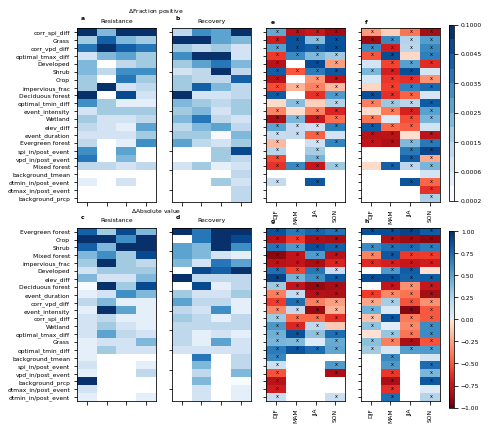

In [70]:
""" Plot the importance values of all the predictors
    Plot the partial dependence relationship of all the predictors using Spearman's rho, with significance
    Ordered based on the ranks of the predictors
"""
importance_ = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_importance{suffix}.csv'),
                          header = [0, 1, 2], index_col = 0)
dependency_ = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_dependency{suffix}.csv'),
                          header = [0, 1], index_col = [0, 1, 2])

ranks = pd.DataFrame(np.nan, index = importance_.index, columns = importance_.columns)
for i in range(ranks.shape[1]):
    vars = importance_.iloc[:, i].fillna(-9999999.) # make the rank lowest
    vars = pd.Series(range(1, 1 + len(vars)), index = vars.sort_values()[::-1].index) # descending
    ranks.loc[vars.index, importance_.columns[i]] = vars
ranks = ranks.stack().stack().stack()
ranks.index.names = ['predictors', 'season', 'which', 'stat']
ranks = ranks.to_frame('rank').reset_index()
ranks_median = ranks.groupby(['predictors', 'which']).mean()['rank'].unstack()


rcParams['font.size'] = 6
rcParams['axes.titlesize'] = 6
lab = 'abcdefghijklmno'

fig, axes = plt.subplots(2, 4, figsize = (6.5, 7), sharey = False)
fig.subplots_adjust(hspace = 0.1)

for j, which in enumerate(['Sign', 'Mag']):
    top_predictors = ranks_median.loc[:, which].sort_values().index

    for i, stat in enumerate(['Resistance', 'Recovery']):
        ax = axes[j, i]
        temp = importance_.loc[top_predictors, (stat, which)]
        cf = ax.imshow(temp, cmap = 'Blues', aspect = 0.4, 
                       norm = BoundaryNorm([0.0002, 0.0004, 0.0006, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.1], ncolors = 256, extend = 'neither'))
        if i == 0:
            ax.set_yticks(range(len(top_predictors)))
            ax.set_yticklabels(top_predictors)
        else:
            ax.set_yticklabels([])
        ax.set_xticks(range(4))
        ax.set_xticklabels([])
        ax.set_title(stat)
        if i == 0:
            if which == 'Sign':
                ax.text(1., 1.09, '$\Delta$Fraction positive', transform = ax.transAxes, horizontalalignment = 'center')
            else:
                ax.text(1., 1.09, '$\Delta$Absolute value', transform = ax.transAxes, horizontalalignment = 'center')
        ax.text(0.05, 1.05, lab[i + j*2], fontweight = 'bold', transform = ax.transAxes)

        if (i + j*2) == 3:
            cax = fig.add_axes([0.92, 0.53, 0.01, 0.35])
            plt.colorbar(cf, cax = cax, orientation = 'vertical')

        ax = axes[j, i + 2]
        temp = dependency_.loc[(stat, which), 'corr'].T.loc[top_predictors, :]
        temp_p = dependency_.loc[(stat, which), 'pval'].T.loc[top_predictors, :]
        cf = ax.imshow(temp, cmap = cmap_div(thres = 0.1), vmin = -1, vmax = 1, aspect = 0.4)

        for a, b in it.product(range(temp.shape[0]), range(temp.shape[1])):
            if temp_p.iloc[a, b] <= 0.05:
                ax.text(b, a, 'x', fontsize = 5)

        ax.set_yticks(range(temp.shape[0]))
        ax.set_yticklabels([])
        ax.set_xticks(range(4))
        ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'], rotation = 90)
        ax.text(0.05, 1.03, lab[4 + i + j*2], fontweight = 'bold', transform = ax.transAxes)

        if (i + j*2) == 3:
            cax = fig.add_axes([0.92, 0.12, 0.01, 0.35])
            plt.colorbar(cf, cax = cax, orientation = 'vertical')

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
fig.savefig(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_importance{suffix}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
# plt.close(fig)

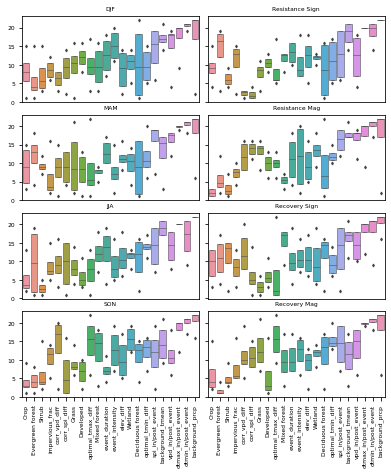

In [14]:
"""Plot the ranks of the predictors in their importance, grouped by season/by sign or magnitude
"""
fig, axes = plt.subplots(4, 2, figsize = (6.5, 7), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.15, wspace = 0.05)
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = axes[i, 0]
    g = sns.boxplot(x = 'predictors', y = 'rank',
                    data = ranks.loc[ranks['season'] == season, :], ax = ax, order = top_predictors, 
                    whis = [10, 90], linewidth = 0.5, fliersize = 2)
    plt.setp(ax.get_xticklabels(), rotation = 90)
    ax.set_title(season)
    ax.legend([], [], frameon = False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if i < 3:
        ax.tick_params('x',length = 0)

for i, stat in enumerate(['Resistance', 'Recovery']):
    for j, which in enumerate(['Sign', 'Mag']):
        ax = axes[i*2 + j, 1]
        g = sns.boxplot(x = 'predictors', y = 'rank',
                        data = ranks.loc[(ranks['stat'] == stat) & (ranks['which'] == which), :], 
                        ax = ax, order = top_predictors, whis = [10, 90], linewidth = 0.5, fliersize = 2)
        plt.setp(ax.get_xticklabels(), rotation = 90)
        ax.set_title(f'{stat} {which}')
        ax.legend([], [], frameon = False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if (i*2 + j) < 3:
            ax.tick_params('x', length = 0)

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
fig.savefig(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_importance_summary{suffix}.png'), dpi = 600., bbox_inches = 'tight')
# bplt.close(fig)

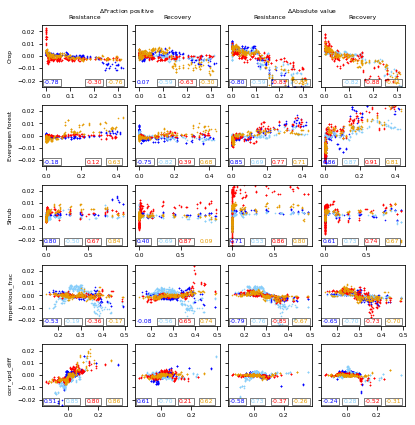

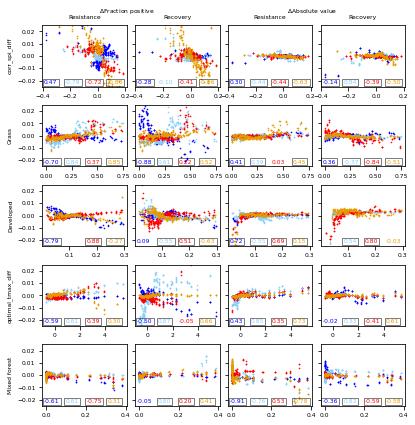

In [15]:
""" Plot the partial dependence relationship as scatter plots of the top 5 + 5 most important predictors """
importance_ = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_importance{suffix}.csv'),
                          header = [0, 1, 2], index_col = 0)
dependency_ = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_dependency{suffix}.csv'),
                          header = [0, 1, 2], index_col = [0, 1])

clist = ['#0000ff', '#87cefa', '#ff0000', '#e69b00']
rcParams['font.size'] = 6
rcParams['axes.titlesize'] = 6
lab = 'abcdefghijklmno'

for add in [0, 5]:
    top_predictors_ = top_predictors[add:(add + 5)]

    fig, axes = plt.subplots(len(top_predictors_), 4, figsize = (6.5, 7), sharey = True)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.1)
    for i, stat in enumerate(['Resistance', 'Recovery']):
        for j, which in enumerate(['Sign', 'Mag']):
            for k, pred in enumerate(top_predictors_):
                ax = axes[k, i + j*2]

                h = [None] * 4
                for m, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
                    if pred in shap_values_collect[(stat, which, season)].columns:
                        x = predictors.loc[season, pred]
                        y = shap_values_collect[(stat, which, season)][pred]
                        #filt = (x >= np.nanpercentile(x, 10)) & (x <= np.nanpercentile(x, 90))
                        #x = x[filt]
                        #y = y[filt]
                        h[m], = ax.plot(x, y, 'o', ms = 0.6, color = clist[m])

                        rho, pval = spearmanr(x, y)
                        
                        if pval <= 0.05:
                            kwargs = {'bbox': dict(facecolor = 'none', edgecolor = 'k', pad = 1, lw = 0.5)}
                        else:
                            kwargs = {}
                        ax.text(m * 0.25 + 0.02, 0.05, f'{rho:.2f}', transform = ax.transAxes, color = clist[m], **kwargs)

                if (i == 0) & (j == 0):
                    ax.set_ylabel(pred)
                if k == 0:
                    ax.set_title(stat)
                    if i == 0:
                        if which == 'Sign':
                            ax.text(1., 1.2, '$\Delta$Fraction positive', transform = ax.transAxes, horizontalalignment = 'center')
                        else:
                            ax.text(1., 1.2, '$\Delta$Absolute value', transform = ax.transAxes, horizontalalignment = 'center')

                ax.set_ylim([-0.025, 0.025])

    fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
    fig.savefig(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_dependency_{add}{suffix}.png'), dpi = 600., bbox_inches = 'tight')
    # plt.close(fig)

In [16]:
""" Interaction between the top 5 predictors, and the temporal factors
  intensity & duration of the events
  urban heat island size during/after the event
  spi & vpd during/after the event

  Not very useful
"""
clist = ['#0000ff', '#87cefa', '#ff0000', '#e69b00']
rcParams['font.size'] = 6
rcParams['axes.titlesize'] = 6

top_predictors_ = top_predictors[:5]

for stat, which, season in it.product(['Resistance', 'Recovery'], ['Sign', 'Mag'], ['DJF', 'MAM', 'JJA', 'SON']):
    fig, axes = plt.subplots(len(top_predictors_), 6, figsize = (6.5, 7))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.1)

    if stat == 'Resistance':
        time_predictors = ['event_intensity', 'event_duration', 'dtmax_in_event', 'dtmin_in_event', 'spi_in_event', 'vpd_in_event']
    else:
        time_predictors = ['event_intensity', 'event_duration', 'dtmax_post_event', 'dtmin_post_event', 'spi_post_event', 'vpd_post_event']

    for i, ap in enumerate(top_predictors_):
        for j, bp in enumerate(time_predictors):
            ax = axes[i, j]

            if ap in shap_values_collect[(stat, which, season)].columns:
                x = predictors.loc[season, bp]
                y = predictors.loc[season, ap]
                c = shap_values_collect[(stat, which, season)][ap]
                ax.scatter(x, y, c = c, cmap = 'RdYlBu', vmin = c.min(), vmax = c.max(), s = 1)

            if j == 0:
                ax.set_ylabel(bp)
            if i == (len(time_predictors) - 1):
                ax.set_xlabel(ap)

    fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
    fig.savefig(os.path.join(path_out, 'measures', 'regression_per_city', folder, f'percity_spatial_avg_summary_{fix}_{self.extreme}_dependency{suffix}_{stat}_{which}_{season}.png'), dpi = 600., bbox_inches = 'tight')
    plt.close(fig)